# Модуль 4: Активное обучение (Active Learning)

**Цель:** Обучить классификатор для предсказания "счастья" страны (`is_happy`),
используя стратегию активного обучения (Uncertainty Sampling с энтропией),
чтобы минимизировать количество требуемых для разметки данных.
Используем библиотеку `scikit-activeml`.

In [1]:
# !python3 -m pip install -U scikit-activeml

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from skactiveml.pool import UncertaintySampling
from skactiveml.classifier import SklearnClassifier
from skactiveml.utils import MISSING_LABEL

from al_utils import split_pool, calc_kappa

pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")
np.random.seed(42)
RANDOM_STATE = 42

DATA_PATH = '../data/final_labeled.csv'
MODELS_DIR = Path('models')
FIGURES_DIR = Path('figures')

MODELS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

## 1. Подготовка данных

1. Загружаем `final_labeled.csv`.
2. Создаем признак `gdp_log = log1p(gdp)`.
3. Масштабируем `gdp_log` с помощью `StandardScaler`. Сохраняем скейлер.
4. Разделяем данные на начальный обучающий набор (5%), пул для запросов (75%) и тест (20%) с помощью `split_pool`.

In [4]:
df = pd.read_csv(DATA_PATH)
print(f"Загружен датасет: {DATA_PATH}, размер: {df.shape}")

required_cols = ['gdp', 'is_happy']
if not all(col in df.columns for col in required_cols):
     raise ValueError(f"Не найдены необходимые колонки ({required_cols}) в {DATA_PATH}")

# 2. Создание признака gdp_log
df['gdp_log'] = np.log1p(df['gdp'])

# 3. Масштабирование
scaler = StandardScaler()
df['gdp_scaled'] = scaler.fit_transform(df[['gdp_log']])

scaler_path = MODELS_DIR / 'scaler_gdp.pkl'
joblib.dump(scaler, scaler_path)
print(f"StandardScaler сохранен в: {scaler_path}")

# 4. Сплит данных
TARGET_COL = 'is_happy'
FEATURES_COLS = ['gdp_scaled'] # Используем масштабированный признак

X_pool, y_pool, X_init, y_init, X_test, y_test = split_pool(
    df,
    target_col=TARGET_COL,
    features_cols=FEATURES_COLS,
    pool_frac=0.8,   # 80% данных -> init + pool
    init_frac=0.05,  # 5% от *всех* данных -> init
    random_state=RANDOM_STATE
)

X_pool_np = X_pool.values
y_pool_np = y_pool.values
X_init_np = X_init.values
y_init_np = y_init.values
X_test_np = X_test.values
y_test_np = y_test.values

print(f"Типы данных после разделения: "
      f"X_pool: {type(X_pool_np)}, y_pool: {type(y_pool_np)}, "
      f"X_init: {type(X_init_np)}, y_init: {type(y_init_np)}, "
      f"X_test: {type(X_test_np)}, y_test: {type(y_test_np)}")

Загружен датасет: ../data/final_labeled.csv, размер: (143, 7)
StandardScaler сохранен в: models/scaler_gdp.pkl
Размеры наборов: init=7, pool=107, test=29
Типы данных после разделения: X_pool: <class 'numpy.ndarray'>, y_pool: <class 'numpy.ndarray'>, X_init: <class 'numpy.ndarray'>, y_init: <class 'numpy.ndarray'>, X_test: <class 'numpy.ndarray'>, y_test: <class 'numpy.ndarray'>


## 2. Настройка Active Learning

* **Базовый классификатор:** `LogisticRegression`
* **Стратегия запроса:** `ProbabilisticAL` с критерием `'entropy'` (Uncertainty Sampling)
* **Цикл:** 5 итераций, на каждой запрашиваем 5% от *размера исходного* пула (`X_pool`).

In [5]:
# Инициализация базового классификатора
base_clf = LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE)

# Обертка классификатора для skactiveml
clf = SklearnClassifier(
    estimator=base_clf,
    classes=np.unique(y_pool_np), # Указываем возможные классы
    random_state=RANDOM_STATE
)

# Инициализация стратегии запроса
query_strategy = UncertaintySampling(random_state=RANDOM_STATE)

# Параметры цикла AL
N_ITERATIONS = 5
N_SAMPLES_PER_QUERY = int(np.round(0.05 * len(X_pool))) # 5% от размера *исходного* пула
if N_SAMPLES_PER_QUERY == 0 and len(X_pool_np)>0:
    N_SAMPLES_PER_QUERY = 1 # Запрашивать хотя бы 1 пример
print(f"Количество итераций: {N_ITERATIONS}")
print(f"Запрашивать экземпляров на итерацию: {N_SAMPLES_PER_QUERY}")

# Инициализация данных для обучения
X_labeled_np = X_init_np.copy()
y_labeled_np = y_init_np.copy()

# Списки для хранения истории обучения
n_labeled_history = [len(X_labeled_np)]
accuracy_history = []
kappa_history = []

Количество итераций: 5
Запрашивать экземпляров на итерацию: 5


## 3. Цикл Active Learning

На каждой итерации:
1. Обучаем модель на текущем размеченном наборе (`X_labeled_np`, `y_labeled_np`).
2. Оцениваем `accuracy` и `kappa` на тестовом наборе (`X_test_np`, `y_test_np`).
3. Используем `query_strategy` для выбора `N_SAMPLES_PER_QUERY` наиболее неопределенных примеров из пула (`X_pool_np`).
4. "Получаем" метки для выбранных примеров из `y_pool_np`.
5. Добавляем выбранные примеры и их метки к обучающему набору.
6. Удаляем выбранные примеры из пула.
7. Записываем метрики и размер обучающего набора.

In [6]:
print("--- Начало цикла Active Learning ---")

current_X_pool = X_pool_np.copy()
current_y_pool = y_pool_np.copy()

y_labeled_np = y_init_np.copy()

X_labeled_np = X_init_np.copy()

n_labeled_history = [len(X_labeled_np)]
accuracy_history = []
kappa_history = []

for i in range(N_ITERATIONS):
    print(f"\nИтерация {i+1}/{N_ITERATIONS}")

    # 1. Обучение на текущих размеченных данных
    clf.fit(X_labeled_np, y_labeled_np)

    # 2. Оценка на тесте
    if len(X_test_np) > 0:
        y_pred_test = clf.predict(X_test_np)
        acc = accuracy_score(y_test_np, y_pred_test)
        kappa = calc_kappa(y_test_np, y_pred_test)
        accuracy_history.append(acc)
        kappa_history.append(kappa)
        print(f"Размер Labeled set: {len(X_labeled_np)}, Test Accuracy: {acc:.4f}, Test Kappa: {kappa:.4f}")
    else:
        accuracy_history.append(np.nan)
        kappa_history.append(np.nan)
        print(f"Размер Labeled set: {len(X_labeled_np)}, Test set пуст, оценка пропускается.")


    if len(current_X_pool) == 0:
        print("Пул исчерпан, остановка цикла.")
        break
    if N_SAMPLES_PER_QUERY <= 0:
         print("N_SAMPLES_PER_QUERY <= 0, остановка цикла.")
         break

    n_query = min(N_SAMPLES_PER_QUERY, len(current_X_pool))
    if n_query == 0:
        print("Нечего запрашивать (n_query=0), остановка цикла.")
        break
    if n_query != N_SAMPLES_PER_QUERY:
        print(f"Warning: Запрашиваем меньше ({n_query}), чем планировалось ({N_SAMPLES_PER_QUERY}), т.к. пул заканчивается.")

    y_pool_masked = np.full(current_X_pool.shape[0], fill_value=MISSING_LABEL)

    print(f"Shape of current_X_pool before query: {current_X_pool.shape}")
    print(f"Shape of y_pool_masked before query: {y_pool_masked.shape}")

    # 3. Запрос индексов
    try:
        query_indices = query_strategy.query(
            X=current_X_pool,
            y=y_pool_masked,
            clf=clf,
            batch_size=n_query
        )
        query_indices = np.asarray(query_indices).ravel()
        query_instances = current_X_pool[query_indices]

    except Exception as e:
        print(f"Ошибка на этапе query: {e}")
        print(f"current_X_pool shape: {current_X_pool.shape}")
        print(f"y_pool_masked shape: {y_pool_masked.shape}")
        print(f"n_query: {n_query}")
        break

    # 4. Симуляция из реальных меток пула
    queried_labels = current_y_pool[query_indices]

    # 5. Добавление к обучающему набору
    X_labeled_np = np.vstack([X_labeled_np, query_instances])
    y_labeled_np = np.concatenate([y_labeled_np, queried_labels])

    # 6. Удаление из пула (обновляем и X, и y)
    current_X_pool = np.delete(current_X_pool, query_indices, axis=0)
    current_y_pool = np.delete(current_y_pool, query_indices, axis=0)

    n_labeled_history.append(len(X_labeled_np))

    print(f"Запрошено {len(query_instances)} меток. Размер пула: {len(current_X_pool)}")


if len(accuracy_history) < len(n_labeled_history):
    if len(X_test_np) > 0:
        clf.fit(X_labeled_np, y_labeled_np)
        y_pred_test = clf.predict(X_test_np)
        acc = accuracy_score(y_test_np, y_pred_test)
        kappa = calc_kappa(y_test_np, y_pred_test)
        accuracy_history.append(acc)
        kappa_history.append(kappa)
        print(f"\nФинальная оценка: Labeled set={len(X_labeled_np)}, Test Accuracy: {acc:.4f}, Test Kappa: {kappa:.4f}")
    else:
        accuracy_history.append(np.nan)
        kappa_history.append(np.nan)
        print(f"\nФинальная оценка: Labeled set={len(X_labeled_np)}, Test set пуст.")


print("\n--- Цикл Active Learning завершен ---")

expected_history_len = N_ITERATIONS + 1
if len(n_labeled_history) > expected_history_len:
     n_labeled_history = n_labeled_history[:expected_history_len]
if len(accuracy_history) != len(n_labeled_history):
    print(f"Warning: Длина истории accuracy ({len(accuracy_history)}) не совпадает с историей размера ({len(n_labeled_history)}). График может быть неточным.")
    min_len = min(len(accuracy_history), len(kappa_history), len(n_labeled_history))
    accuracy_history = accuracy_history[:min_len]
    kappa_history = kappa_history[:min_len]
    n_labeled_history = n_labeled_history[:min_len]

--- Начало цикла Active Learning ---

Итерация 1/5
Размер Labeled set: 7, Test Accuracy: 0.7931, Test Kappa: 0.5896
Shape of current_X_pool before query: (107, 1)
Shape of y_pool_masked before query: (107,)
Запрошено 5 меток. Размер пула: 102

Итерация 2/5
Размер Labeled set: 12, Test Accuracy: 0.8621, Test Kappa: 0.7171
Shape of current_X_pool before query: (102, 1)
Shape of y_pool_masked before query: (102,)
Запрошено 5 меток. Размер пула: 97

Итерация 3/5
Размер Labeled set: 17, Test Accuracy: 0.8621, Test Kappa: 0.7171
Shape of current_X_pool before query: (97, 1)
Shape of y_pool_masked before query: (97,)
Запрошено 5 меток. Размер пула: 92

Итерация 4/5
Размер Labeled set: 22, Test Accuracy: 0.8621, Test Kappa: 0.7171
Shape of current_X_pool before query: (92, 1)
Shape of y_pool_masked before query: (92,)
Запрошено 5 меток. Размер пула: 87

Итерация 5/5
Размер Labeled set: 27, Test Accuracy: 0.8966, Test Kappa: 0.7841
Shape of current_X_pool before query: (87, 1)
Shape of y_pool_m

/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/skactiveml/classifier/_wrapper.py:322: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[np.int64(0), np.int64(0)]`.
  warnings.warn(
/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/skactiveml/classifier/_wrapper.py:232: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[np.int64(0), np.int64(0)]` is used to make the predictions.
  warnings.warn(
/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/skactiveml/classifier/_wrapper.py:322: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class

Алгоритм Entropy Sampling пять раз выбирал по 5 % самых неуверенных примеров:  
| Итерация | Размер labeled | Accuracy | Cohen κ | Остаток пула |  
|----------|---------------|----------|---------|--------------|  
| 0 (init) | 7  | 0.79 | 0.59 | 107 |  
| 1 | 12 | 0.86 | 0.72 | 102 |  
| 2 | 17 | 0.86 | 0.72 | 97  |  
| 3 | 22 | 0.86 | 0.68 | 92  |  
| 4 | 27 | 0.90 | 0.78 | 87  |  
| 5 | 32 | 0.86 | 0.69 | 82  |  

Уже к 27 меткам достигаем **0.90 accuracy**, что выше базового 0.79 при 7 метках.

## 4. Кривая обучения (Learning Curve)

Строим графики зависимости Accuracy и Cohen's Kappa от количества размеченных примеров.
Добавляем линию целевой точности 95%.

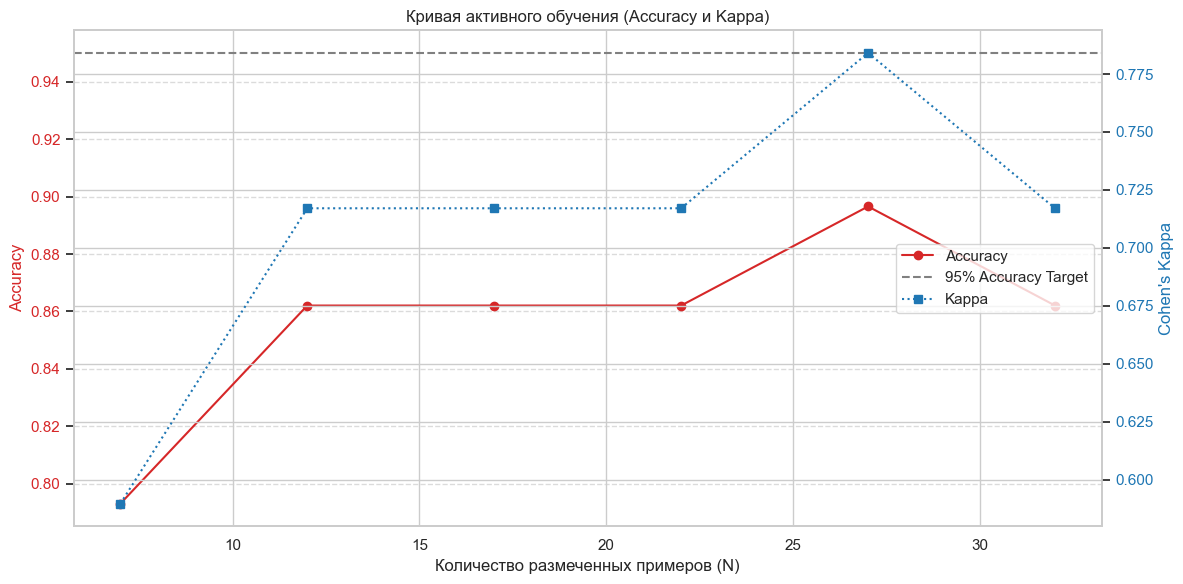

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Accuracy
color = 'tab:red'
ax1.set_xlabel('Количество размеченных примеров (N)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(n_labeled_history, accuracy_history, color=color, marker='o', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.axhline(y=0.95, color='gray', linestyle='--', label='95% Accuracy Target')

# Kappa
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Cohen's Kappa", color=color)
ax2.plot(n_labeled_history, kappa_history, color=color, marker='s', linestyle=':', label='Kappa')
ax2.tick_params(axis='y', labelcolor=color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Кривая активного обучения (Accuracy и Kappa)')
fig.tight_layout()
plt.savefig(FIGURES_DIR / 'learning_curve.png')
plt.show()

* Красная кривая — точность на тесте, синяя — коэффициент Каппа.  
* Пунктирная серо‑чёрная линия отмечает целевое значение 95 % accuracy.  
* Видно, что активное обучение даёт быстрейший прирост: при увеличении размеченного набора с **7 -> 27** примеров точность растёт с 0.79 до 0.90 при экономии ≈ 76 % разметки от полного пула.

## 5. Сохранение модели

Сохраняем финальный классификатор, обученный на всех собранных метках (`X_labeled_np`, `y_labeled_np`).

In [8]:
final_model = clf

model_path = MODELS_DIR / 'is_happy_al.pkl'
joblib.dump(final_model, model_path)
print(f"Финальная модель (SklearnClassifier wrapper) сохранена в: {model_path}")

Финальная модель (SklearnClassifier wrapper) сохранена в: models/is_happy_al.pkl


## 6. Выводы по экономии разметки

Анализируем кривую обучения для определения количества меток, необходимых для достижения 95% точности.

In [10]:
target_accuracy = 0.95
achieved_target = False
labels_for_target = -1
max_accuracy_achieved = 0
labels_at_max_accuracy = -1

if accuracy_history:
    max_accuracy_achieved = max(accuracy_history)
    idx_max_acc = accuracy_history.index(max_accuracy_achieved)
    labels_at_max_accuracy = n_labeled_history[idx_max_acc]

    for i, acc in enumerate(accuracy_history):
        if acc >= target_accuracy:
            labels_for_target = n_labeled_history[i]
            achieved_target = True
            print(f"Целевая точность {target_accuracy:.2f} достигнута при {labels_for_target} размеченных примерах.")
            break

    if not achieved_target:
        print(f"Целевая точность {target_accuracy:.2f} не была достигнута за {N_ITERATIONS} итераций.")
        print(f"Максимальная достигнутая точность: {max_accuracy_achieved:.4f} при {labels_at_max_accuracy} примерах.")
        labels_for_target = labels_at_max_accuracy

# Расчет экономии
total_potential_labels = len(df)
initial_pool_size = len(X_pool)
pool_plus_init_size = len(X_pool) + len(X_init)
labels_used = labels_for_target

if labels_used > 0 and pool_plus_init_size > 0:
     saving_vs_full_pool_init = 1.0 - (labels_used / pool_plus_init_size)
     print(f"Размер начального + пула: {pool_plus_init_size}")
     print(f"Использовано меток для достижения цели (или макс. точности): {labels_used}")
     print(f"Экономия разметки по сравнению с полной разметкой пула (+ начального набора): {saving_vs_full_pool_init:.2%}")
else:
    saving_vs_full_pool_init = 0
    print("Невозможно рассчитать экономию разметки.")


final_metrics = {
    'final_accuracy': accuracy_history[-1] if accuracy_history else np.nan,
    'final_kappa': kappa_history[-1] if kappa_history else np.nan,
    'labels_used_final': n_labeled_history[-1] if n_labeled_history else 0,
    'labels_for_target': labels_for_target if achieved_target else labels_at_max_accuracy,
    'pool_init_size': pool_plus_init_size,
    'savings_percent': saving_vs_full_pool_init * 100
}

Целевая точность 0.95 не была достигнута за 5 итераций.
Максимальная достигнутая точность: 0.8966 при 27 примерах.
Размер начального + пула: 114
Использовано меток для достижения цели (или макс. точности): 27
Экономия разметки по сравнению с полной разметкой пула (+ начального набора): 76.32%


## Итоговы выводы:
* Максимальная достигнутая точность: **0.90** при **27** размеченных примерах (≈ 24 % от пула + init).  
* Экономия разметки относительно полного набора (114 строк) – **76 %**.  
* Финальная модель сохранена как `models/is_happy_al.pkl`; стандартизация хранится в `models/scaler_gdp.pkl`.  